In this notebook, we'll explore how information propagates through a graph in the Graph Neural Network (GNN) model. We'll implement the iterative scheme for computing stable states, explain the Banach fixed point theorem, and visualize the diffusion process on simple graph examples.

## 1. Introduction to Information Diffusion in GNNs

One of the most powerful aspects of Graph Neural Networks is their ability to propagate information across the graph structure. This process, known as **information diffusion**, allows each node to gather and incorporate information from its neighborhood and, eventually, from the entire graph.

### 1.1 The Concept of Information Diffusion

Information diffusion in GNNs refers to how signals (or information) propagate from node to node through the graph edges during the iterative state update process. This is analogous to:

- Heat diffusion in physical systems
- Message passing in probabilistic graphical models
- Signal propagation in neural circuits
- Information spreading in social networks

The key difference in GNNs is that this diffusion process is **learnable** - the parameters that control how information flows are learned from data.

### 1.2 Iterative State Updates as Diffusion

In Scarselli et al.'s GNN model, the state update equation for a node v at iteration t is:

$$h_v^{(t)} = f_w(x_v, x_{co[v]}, h_{ne[v]}^{(t-1)}, x_{ne[v]})$$

Where:
- $h_v^{(t)}$ is the state of node $v$ at iteration $t$
- $f_w$ is the local transition function with parameters $w$
- $x_v$ is the feature vector of node $v$
- $x_{co[v]}$ represents the features of edges connected to $v$
- $h_{ne[v]}^{(t-1)}$ are the states of neighboring nodes from the previous iteration
- $x_{ne[v]}$ are the features of neighboring nodes

This equation describes how information flows from neighbors to the current node in each iteration. Over multiple iterations, information from distant nodes gradually reaches every node in the graph.

## 2. Mathematical Foundations of Diffusion

### 2.1 Fixed Point Iteration

The iterative update process in GNNs can be viewed as a fixed point iteration. For the entire graph, we define a global transition function $F_w$ that updates all node states at once:

$$\mathbf{h}^{(t)} = F_w(\mathbf{x}, \mathbf{h}^{(t-1)})$$

Where $\mathbf{h}^{(t)}$ and $\mathbf{x}$ are the collections of all node states and features, respectively.

The goal is to find the fixed point of this function:

$$\mathbf{h}^{*} = F_w(\mathbf{x}, \mathbf{h}^{*})$$

### 2.2 Banach Fixed Point Theorem

The key mathematical result that guarantees the convergence of this iterative process is the **Banach fixed point theorem** (also known as the contraction mapping principle):

**Theorem**: Let $(X, d)$ be a non-empty complete metric space with a contraction mapping $T: X \rightarrow X$. Then:
1. $T$ has a unique fixed point $x^*$ in $X$
2. For any starting point $x_0 \in X$, the sequence $\{x_n\}$ defined by $x_n = T(x_{n-1})$ converges to $x^*$
3. We have the error bound: $d(x_n, x^*) \leq \frac{\mu^n}{1-\mu} d(x_1, x_0)$ where $\mu$ is the contraction coefficient

### 2.3 Contraction Mapping

A function $F: X \rightarrow X$ is a contraction mapping on a metric space $(X, d)$ if there exists a constant $0 \leq \mu < 1$ such that:

$$d(F(x), F(y)) \leq \mu \cdot d(x, y) \quad \forall x, y \in X$$

In the context of GNNs, this means that the distance between the updated states of two different initial states becomes smaller after each application of the transition function. This property ensures that the states will eventually converge to a unique fixed point regardless of the initial state.

### 2.4 Convergence Rate

The Banach fixed point theorem also provides an upper bound on the convergence rate. If $\mu$ is the contraction coefficient, then after $n$ iterations, the distance to the fixed point is bounded by:

$$d(\mathbf{h}^{(n)}, \mathbf{h}^*) \leq \frac{\mu^n}{1-\mu} d(\mathbf{h}^{(1)}, \mathbf{h}^{(0)})$$

This means that the convergence is exponential, with smaller $\mu$ values leading to faster convergence.

## 3. Implementing the Iterative Diffusion Process

Let's implement the iterative state update process in a way that allows us to visualize and analyze the diffusion of information. We'll use PyTorch for our implementation.

### 3.1 Data Structures for Tracking Diffusion

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

class DiffusionTracker:
    """
    Class to track and analyze the diffusion of information in a GNN.
    """
    def __init__(self, graph, initial_states=None, state_dim=3):
        """
        Initialize the diffusion tracker.
        
        Args:
            graph: NetworkX graph
            initial_states: Dictionary mapping node IDs to initial state tensors (optional)
            state_dim: Dimension of state vectors (used if initial_states is None)
        """
        self.graph = graph
        self.state_dim = state_dim
        
        # Initialize states if not provided
        if initial_states is None:
            self.states = {node: torch.zeros(state_dim) for node in graph.nodes()}
        else:
            self.states = initial_states
        
        # Track state history
        self.state_history = [self.copy_states(self.states)]
        
        # Track convergence metrics
        self.convergence_metrics = []
    
    def copy_states(self, states):
        """Create a deep copy of states dictionary."""
        return {node: state.clone() for node, state in states.items()}
    
    def update_states(self, transition_function, node_features, edge_features=None):
        """
        Update all node states using the transition function.
        
        Args:
            transition_function: Function that computes new state from node features and neighbor states
            node_features: Dictionary mapping node IDs to feature tensors
            edge_features: Dictionary mapping (source, target) tuples to edge feature tensors (optional)
        
        Returns:
            Maximum change in any state vector
        """
        new_states = {}
        
        # Update each node's state
        for node in self.graph.nodes():
            # Get neighbor states
            neighbors = list(self.graph.neighbors(node))
            neighbor_states = [self.states[neigh] for neigh in neighbors]
            
            # Get edge features if provided
            edges_feat = None
            if edge_features is not None:
                edge_pairs = [(node, neigh) for neigh in neighbors]
                edges_feat = [edge_features.get(edge, torch.zeros(1)) for edge in edge_pairs]
            
            # Update state using transition function
            new_state = transition_function(
                node_features[node], neighbor_states, edges_feat
            )
            
            new_states[node] = new_state
        
        # Calculate maximum change
        max_change = 0.0
        for node in self.graph.nodes():
            change = torch.norm(new_states[node] - self.states[node]).item()
            max_change = max(max_change, change)
        
        # Update states
        self.states = new_states
        
        # Add to history
        self.state_history.append(self.copy_states(self.states))
        
        # Track convergence metric
        self.convergence_metrics.append(max_change)
        
        return max_change
    
    def run_diffusion(self, transition_function, node_features, edge_features=None, 
                      max_iterations=20, convergence_threshold=1e-6):
        """
        Run the diffusion process until convergence or max iterations.
        
        Args:
            transition_function: Function that computes new state from node features and neighbor states
            node_features: Dictionary mapping node IDs to feature tensors
            edge_features: Dictionary mapping (source, target) tuples to edge feature tensors (optional)
            max_iterations: Maximum number of iterations
            convergence_threshold: Threshold for convergence
            
        Returns:
            Number of iterations until convergence
        """
        for iteration in range(max_iterations):
            max_change = self.update_states(transition_function, node_features, edge_features)
            
            if max_change < convergence_threshold:
                print(f"Converged after {iteration + 1} iterations")
                return iteration + 1
        
        print(f"Did not converge after {max_iterations} iterations. Final change: {max_change:.6f}")
        return max_iterations
    
    def get_state_at_iteration(self, iteration):
        """Get the states at a specific iteration."""
        if 0 <= iteration < len(self.state_history):
            return self.state_history[iteration]
        else:
            raise ValueError(f"Invalid iteration: {iteration}. History has {len(self.state_history)} entries.")
    
    def get_convergence_metrics(self):
        """Get the convergence metrics over iterations."""
        return self.convergence_metrics

### 3.2 Simple Transition Function for Visualization

Let's implement a simple transition function to visualize the diffusion process:

In [2]:
class SimpleTransitionFunction:
    """
    A simple transition function for visualizing diffusion.
    
    This function can be configured to show different diffusion patterns.
    """
    def __init__(self, state_dim, diffusion_rate=0.5):
        """
        Initialize the simple transition function.
        
        Args:
            state_dim: Dimension of state vectors
            diffusion_rate: Rate of diffusion (0 to 1)
        """
        self.state_dim = state_dim
        self.diffusion_rate = diffusion_rate
        
        # Create a weight matrix that ensures contraction
        self.weight = torch.eye(state_dim) * (1 - diffusion_rate)
    
    def __call__(self, node_features, neighbor_states, edge_features=None):
        """
        Compute the new state for a node.
        
        Args:
            node_features: Node's feature tensor
            neighbor_states: List of neighbor state tensors
            edge_features: List of edge feature tensors (optional)
            
        Returns:
            New state tensor
        """
        # Part of the state is retained from the previous state
        if len(neighbor_states) == 0:
            # No neighbors, keep the same state
            new_state = node_features.clone()
        else:
            # Aggregate neighbor states (mean pooling)
            neighbor_aggr = torch.stack(neighbor_states).mean(dim=0)
            
            # Combine own features and neighbor states
            # Node retains (1-diffusion_rate) of its state and 
            # receives diffusion_rate from neighbors
            new_state = (1 - self.diffusion_rate) * node_features + self.diffusion_rate * neighbor_aggr
        
        return new_state

### 3.3 Advanced Transition Functions

We can also implement more advanced transition functions that better demonstrate the propagation of information:

In [3]:
class MLPTransitionFunction:
    """
    Neural network-based transition function for diffusion visualization.
    """
    def __init__(self, feature_dim, state_dim, hidden_dim=16):
        """
        Initialize the MLP transition function.
        
        Args:
            feature_dim: Dimension of node features
            state_dim: Dimension of state vectors
            hidden_dim: Dimension of hidden layers
        """
        self.feature_dim = feature_dim
        self.state_dim = state_dim
        
        # Create weight matrices
        self.W_node = torch.randn(state_dim, feature_dim) * 0.1
        self.W_neighbor = torch.randn(state_dim, state_dim) * 0.1
        self.bias = torch.zeros(state_dim)
        
        # Ensure contraction by scaling W_neighbor
        spectral_radius = torch.linalg.matrix_norm(self.W_neighbor, ord=2)
        if spectral_radius >= 1:
            self.W_neighbor = self.W_neighbor / (spectral_radius * 1.5)
    
    def __call__(self, node_features, neighbor_states, edge_features=None):
        """
        Compute the new state for a node.
        
        Args:
            node_features: Node's feature tensor
            neighbor_states: List of neighbor state tensors
            edge_features: List of edge feature tensors (optional)
            
        Returns:
            New state tensor
        """
        # Transform node features
        node_term = torch.matmul(self.W_node, node_features)
        
        # Aggregate and transform neighbor states
        if len(neighbor_states) > 0:
            neighbor_aggr = torch.stack(neighbor_states).mean(dim=0)
            neighbor_term = torch.matmul(self.W_neighbor, neighbor_aggr)
        else:
            neighbor_term = torch.zeros_like(node_term)
        
        # Combine terms and apply activation
        combined = node_term + neighbor_term + self.bias
        new_state = torch.tanh(combined)
        
        return new_state

## 4. Visualizing the Diffusion Process

Now, let's create utilities to visualize how information diffuses through the graph:

In [4]:

def create_node_colors_from_states(graph, states, dim_idx=0, cmap='coolwarm'):
    """
    Create node colors based on state values for visualization.
    
    Args:
        graph: NetworkX graph
        states: Dictionary mapping node IDs to state tensors
        dim_idx: Which dimension of the state to use for coloring (default: 0)
        cmap: Matplotlib colormap to use
        
    Returns:
        List of node colors
    """
    # Extract the specified dimension from each state
    values = [states[node][dim_idx].item() for node in graph.nodes()]
    
    # Normalize values to [-1, 1] range for colormap
    min_val = min(values)
    max_val = max(values)
    abs_max = max(abs(min_val), abs(max_val)) if max_val != min_val else 1.0
    
    # Create a normalized color for each node
    colors = []
    for val in values:
        # Normalize to [-1, 1]
        norm_val = val / abs_max if abs_max > 0 else 0
        # Map to [0, 1] for colormap
        cmap_val = (norm_val + 1) / 2
        colors.append(plt.get_cmap(cmap)(cmap_val))
    
    return colors

def visualize_diffusion_step(graph, states, pos=None, dim_idx=0, cmap='coolwarm', ax=None):
    """
    Visualize a single step of the diffusion process.
    
    Args:
        graph: NetworkX graph
        states: Dictionary mapping node IDs to state tensors
        pos: Node positions for drawing (if None, spring layout is used)
        dim_idx: Which dimension of the state to use for coloring
        cmap: Matplotlib colormap to use
        ax: Matplotlib axis to draw on (if None, a new one is created)
        
    Returns:
        Node positions (for consistent layout across calls)
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    
    if pos is None:
        pos = nx.spring_layout(graph, seed=42)
    
    # Get node colors based on states
    node_colors = create_node_colors_from_states(graph, states, dim_idx, cmap)
    
    # Draw the graph
    nx.draw_networkx(
        graph, pos=pos, ax=ax, node_color=node_colors, 
        node_size=500, with_labels=True, font_weight='bold'
    )
    
    return pos

def visualize_diffusion_process(graph, state_history, dim_idx=0, cmap='coolwarm', max_steps=4):
    """
    Visualize the diffusion process over multiple steps.
    
    Args:
        graph: NetworkX graph
        state_history: List of dictionaries mapping node IDs to state tensors
        dim_idx: Which dimension of the state to use for coloring
        cmap: Matplotlib colormap to use
        max_steps: Maximum number of steps to visualize
    """
    # Determine how many steps to show
    steps = min(len(state_history), max_steps)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, steps, figsize=(5*steps, 5))
    if steps == 1:
        axes = [axes]  # Make sure axes is a list
    
    # Generate consistent layout
    pos = nx.spring_layout(graph, seed=42)
    
    # For each step
    for i in range(steps):
        ax = axes[i]
        states = state_history[i]
        
        # Visualize the diffusion at this step
        visualize_diffusion_step(graph, states, pos, dim_idx, cmap, ax)
        
        ax.set_title(f"Iteration {i}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def create_diffusion_animation(graph, state_history, dim_idx=0, cmap='coolwarm', interval=500):
    """
    Create an animation of the diffusion process.
    
    Args:
        graph: NetworkX graph
        state_history: List of dictionaries mapping node IDs to state tensors
        dim_idx: Which dimension of the state to use for coloring
        cmap: Matplotlib colormap to use
        interval: Time between frames in milliseconds
        
    Returns:
        Animation object
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Generate consistent layout
    pos = nx.spring_layout(graph, seed=42)
    
    # Initialize plot
    visualize_diffusion_step(graph, state_history[0], pos, dim_idx, cmap, ax)
    ax.set_title("Iteration 0")
    ax.axis('off')
    
    # Update function for animation
    def update(frame):
        ax.clear()
        visualize_diffusion_step(graph, state_history[frame], pos, dim_idx, cmap, ax)
        ax.set_title(f"Iteration {frame}")
        ax.axis('off')
        return ax
    
    # Create animation
    anim = FuncAnimation(
        fig, update, frames=len(state_history), interval=interval, blit=False
    )
    
    return anim

### 4.3 Convergence Analysis

To analyze how quickly the diffusion process converges, let's create some visualization tools:

In [7]:
def plot_convergence_metrics(metrics, title="Convergence Analysis"):
    """
    Plot convergence metrics over iterations.
    
    Args:
        metrics: List of convergence metrics (e.g., max change at each iteration)
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(metrics, marker='o', linestyle='-', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Maximum Change", fontsize=12)
    plt.yscale('log')  # Log scale to better show convergence
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1e-6, color='r', linestyle='--', alpha=0.7, label="Convergence Threshold")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_state_dimension_evolution(state_history, node_id, dim_indices=None):
    """
    Plot the evolution of state dimensions for a specific node.
    
    Args:
        state_history: List of dictionaries mapping node IDs to state tensors
        node_id: ID of the node to analyze
        dim_indices: Indices of dimensions to plot (if None, plot all)
    """
    # Extract state dimension
    state_dim = state_history[0][node_id].shape[0]
    
    # Determine which dimensions to plot
    if dim_indices is None:
        dim_indices = range(state_dim)
    
    # Extract values for each dimension over time
    values = []
    for dim_idx in dim_indices:
        dim_values = [states[node_id][dim_idx].item() for states in state_history]
        values.append(dim_values)
    
    # Plot the evolution
    plt.figure(figsize=(10, 6))
    for i, dim_values in enumerate(values):
        plt.plot(dim_values, marker='o', linestyle='-', linewidth=2, 
                 label=f"Dimension {dim_indices[i]}")
    
    plt.title(f"State Evolution for Node {node_id}", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("State Value", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In part 2, we'll demonstrate these diffusion mechanisms on several graph examples and analyze their behavior.

We'll continue our exploration of information diffusion in GNNs by demonstrating the concepts on concrete examples, comparing different diffusion patterns, and exploring how initialization impacts convergence.

## 1. Demonstrating Diffusion on Simple Graph Examples

Let's begin by creating some example graphs and visualizing the diffusion process on them.

### 1.1 Path Graph Example

First, let's consider a simple path graph where information must travel from one end to the other:

Path Graph with 5 nodes and 4 edges


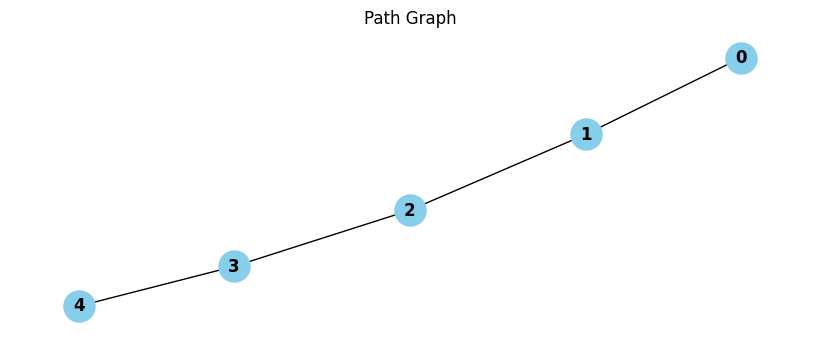

Did not converge after 10 iterations. Final change: 0.001859


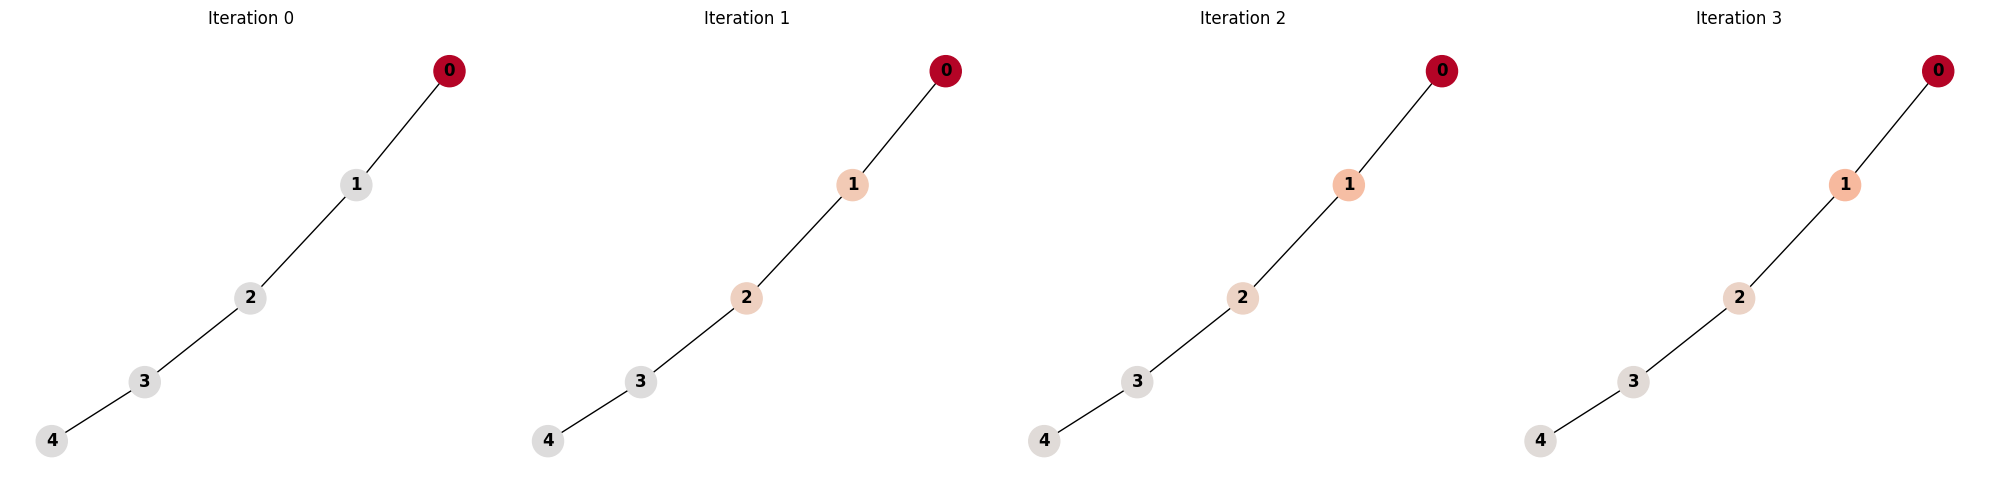

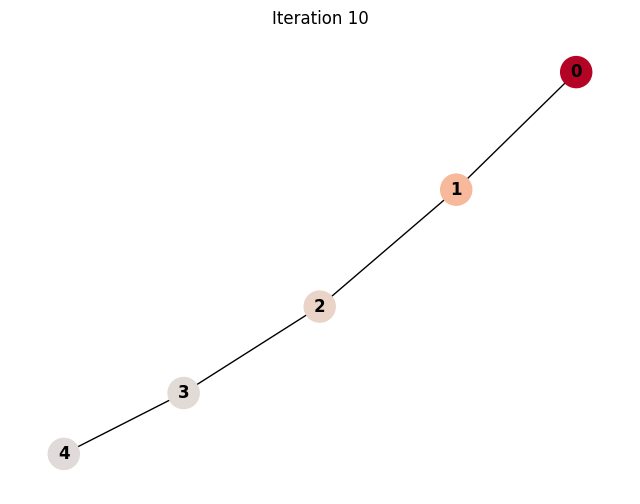

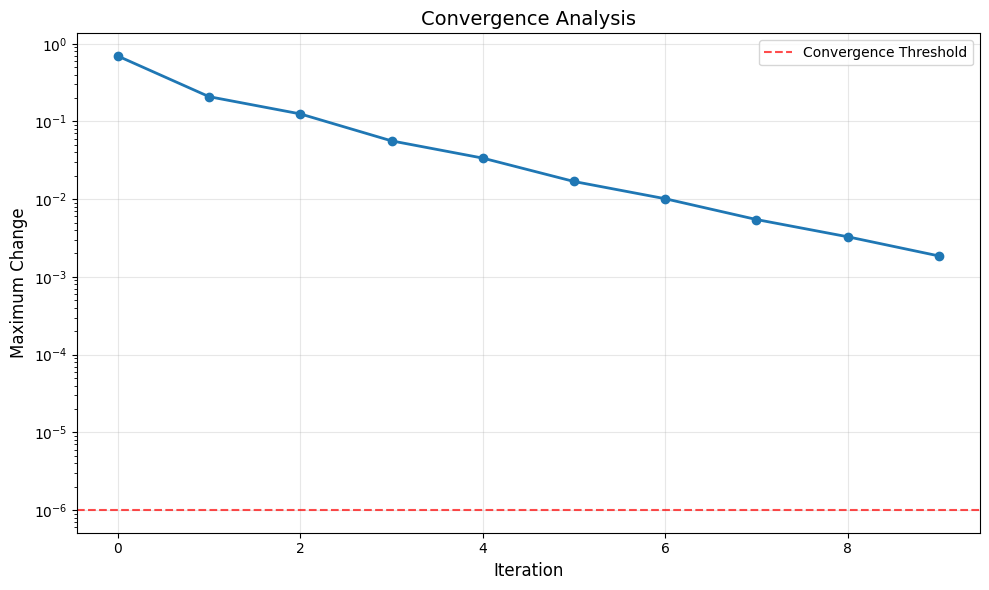

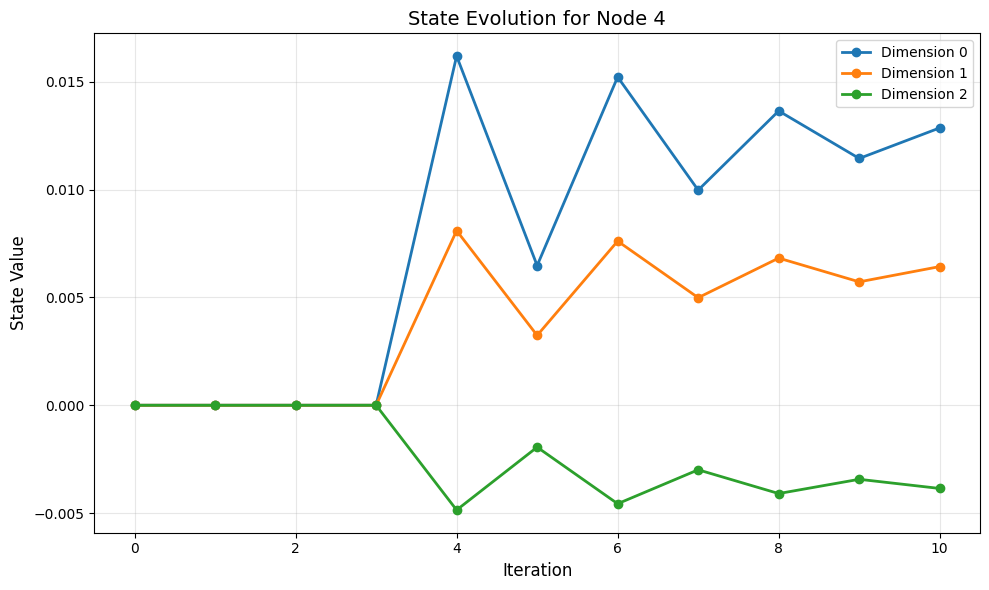

In [9]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Import our diffusion utilities from Part 1
# Assume we've imported or defined the DiffusionTracker and transition functions from Part 1

# Create a path graph
path_graph = nx.path_graph(5)
print(f"Path Graph with {len(path_graph.nodes())} nodes and {len(path_graph.edges())} edges")

# Visualize the graph
plt.figure(figsize=(8, 3))
pos = nx.spring_layout(path_graph, seed=42)
nx.draw(path_graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold')
plt.title("Path Graph")
plt.show()

# Define node features - we'll set node 0 as the source of information
state_dim = 3
node_features = {}
for node in path_graph.nodes():
    if node == 0:
        # Source node has a strong initial signal
        node_features[node] = torch.tensor([1.0, 0.5, -0.3], dtype=torch.float32)
    else:
        # Other nodes have zero initial signal
        node_features[node] = torch.zeros(state_dim, dtype=torch.float32)

# Create a diffusion tracker
tracker = DiffusionTracker(path_graph, initial_states=node_features)

# Create a simple transition function with moderate diffusion rate
transition_fn = SimpleTransitionFunction(state_dim=state_dim, diffusion_rate=0.6)

# Run the diffusion process
iterations = tracker.run_diffusion(
    transition_function=transition_fn,
    node_features=node_features,
    max_iterations=10,
    convergence_threshold=1e-6
)

# Visualize the diffusion process at key steps
visualize_diffusion_process(
    path_graph, 
    [tracker.get_state_at_iteration(i) for i in range(0, iterations+1, 2)],
    dim_idx=0,
    cmap='coolwarm'
)

# Create an animation of the complete diffusion process
anim = create_diffusion_animation(
    path_graph,
    [tracker.get_state_at_iteration(i) for i in range(iterations+1)],
    dim_idx=0
)

# Display the animation
HTML(anim.to_jshtml())

# Plot convergence metrics
plot_convergence_metrics(tracker.get_convergence_metrics())

# Plot state evolution for the last node in the path
plot_state_dimension_evolution(
    [tracker.get_state_at_iteration(i) for i in range(iterations+1)],
    node_id=4,
    dim_indices=[0, 1, 2]
)

In the path graph example, we can observe how information gradually flows from node 0 to the other nodes. The information takes longer to reach nodes that are farther away, illustrating the step-by-step nature of the diffusion process.

### 1.2 Tree Graph Example

Now let's visualize diffusion on a tree graph, where information can spread out in multiple directions:

Tree Graph with 7 nodes and 6 edges


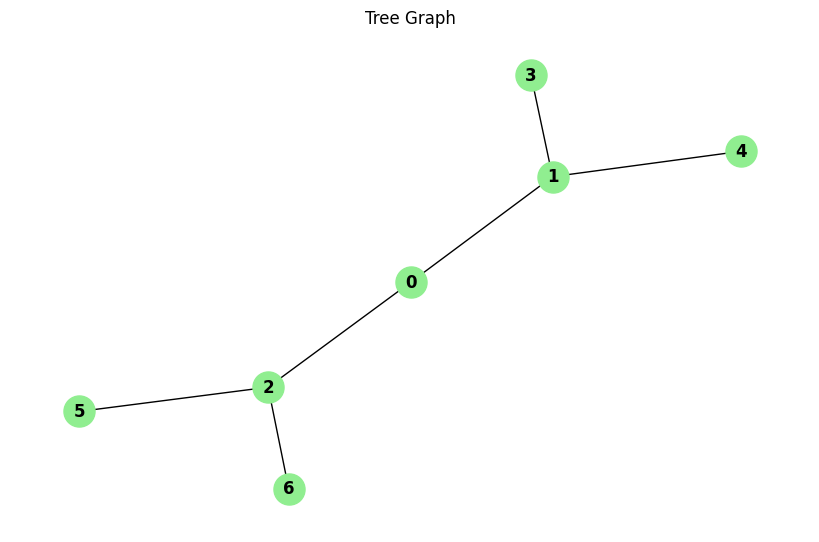

Did not converge after 10 iterations. Final change: 0.002333


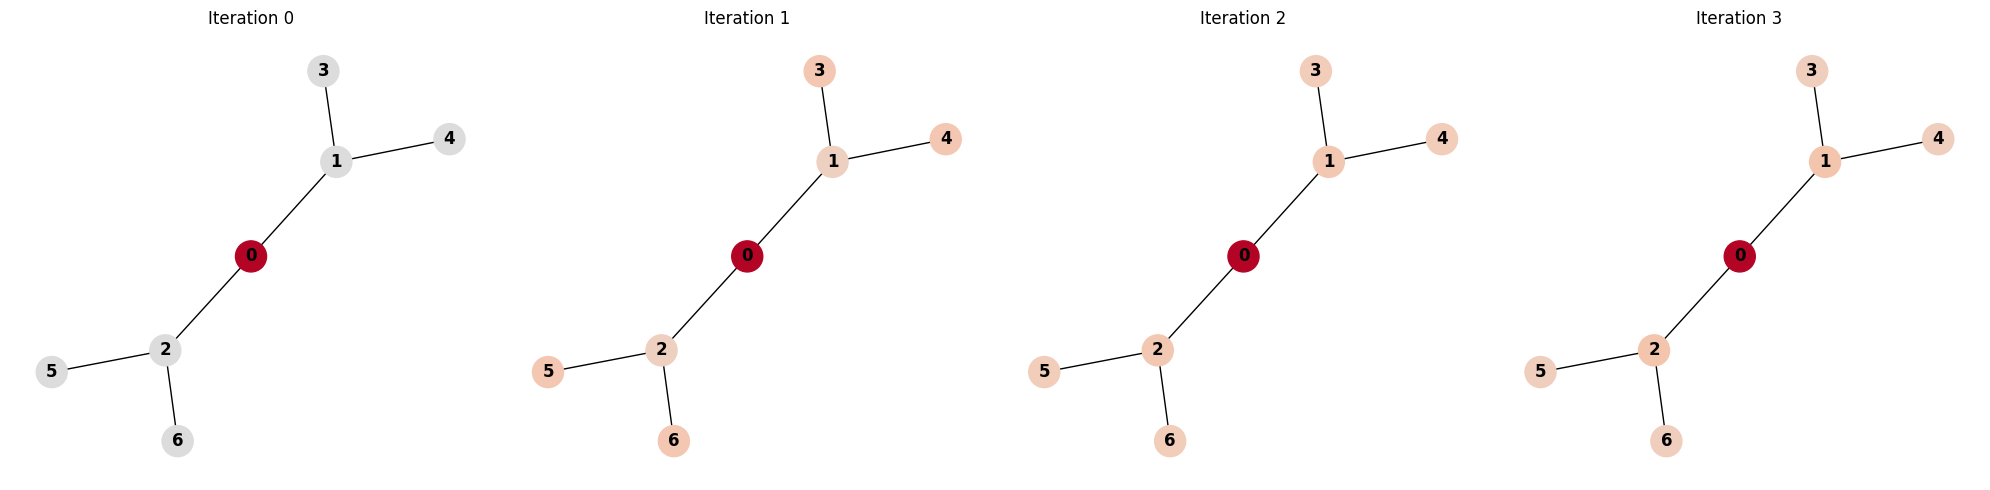

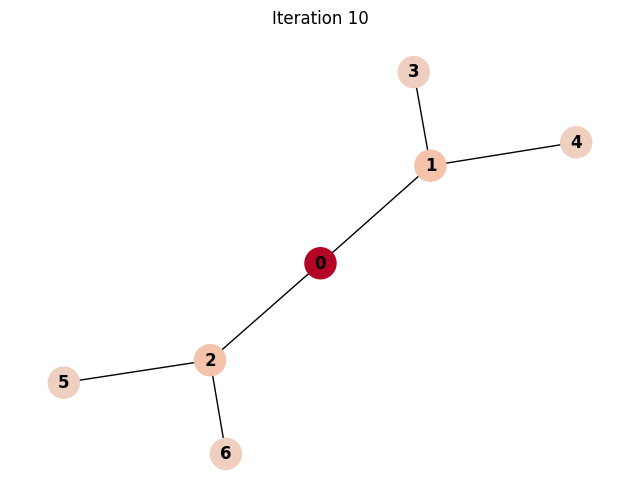

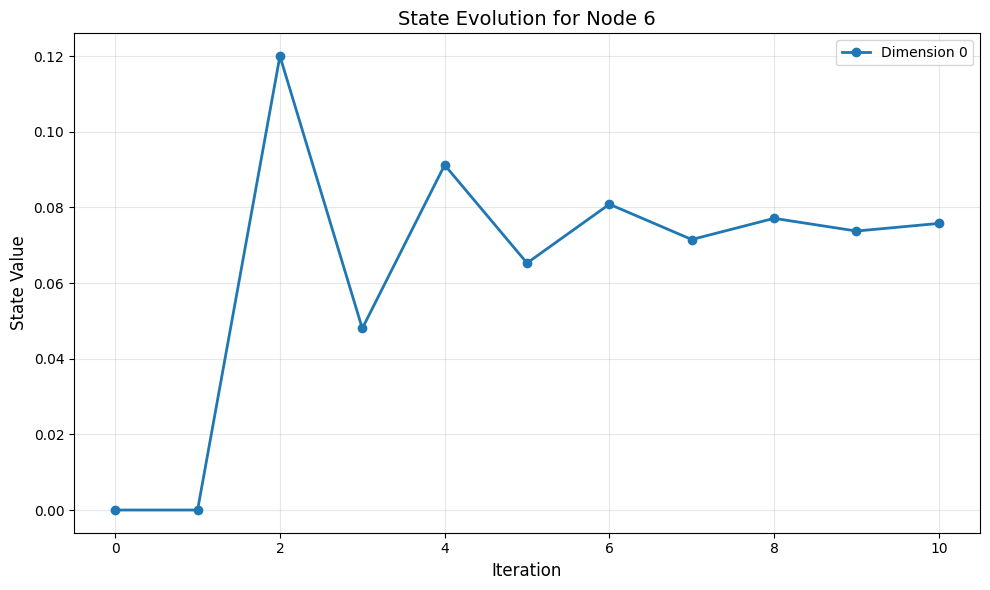

In [10]:
# Create a balanced tree graph
tree_graph = nx.balanced_tree(r=2, h=2)  # Binary tree with height 2
print(f"Tree Graph with {len(tree_graph.nodes())} nodes and {len(tree_graph.edges())} edges")

# Visualize the graph
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(tree_graph, seed=42)
nx.draw(tree_graph, pos, with_labels=True, node_size=500, node_color='lightgreen', font_weight='bold')
plt.title("Tree Graph")
plt.show()

# Define node features - set the root node as the source of information
node_features = {}
for node in tree_graph.nodes():
    if node == 0:
        # Root node has a strong initial signal
        node_features[node] = torch.tensor([1.0, 0.5, -0.3], dtype=torch.float32)
    else:
        # Other nodes have zero initial signal
        node_features[node] = torch.zeros(state_dim, dtype=torch.float32)

# Create a diffusion tracker
tracker = DiffusionTracker(tree_graph, initial_states=node_features)

# Run the diffusion process
iterations = tracker.run_diffusion(
    transition_function=transition_fn,
    node_features=node_features,
    max_iterations=10,
    convergence_threshold=1e-6
)

# Visualize the diffusion process at key steps
visualize_diffusion_process(
    tree_graph, 
    [tracker.get_state_at_iteration(i) for i in range(0, iterations+1, 2)],
    dim_idx=0,
    cmap='coolwarm'
)

# Create an animation of the complete diffusion process
anim = create_diffusion_animation(
    tree_graph,
    [tracker.get_state_at_iteration(i) for i in range(iterations+1)],
    dim_idx=0
)

# Display the animation
HTML(anim.to_jshtml())

# Plot state evolution for a leaf node
leaf_node = len(tree_graph.nodes()) - 1
plot_state_dimension_evolution(
    [tracker.get_state_at_iteration(i) for i in range(iterations+1)],
    node_id=leaf_node,
    dim_indices=[0]
)

In the tree graph, we can observe how information flows from the root outward to all branches simultaneously. This demonstrates how graph structure influences the diffusion pattern.

### 1.3 Cycle Graph Example with Multiple Sources

Let's explore a cycle graph where information is injected at multiple points:

Cycle Graph with 8 nodes and 8 edges


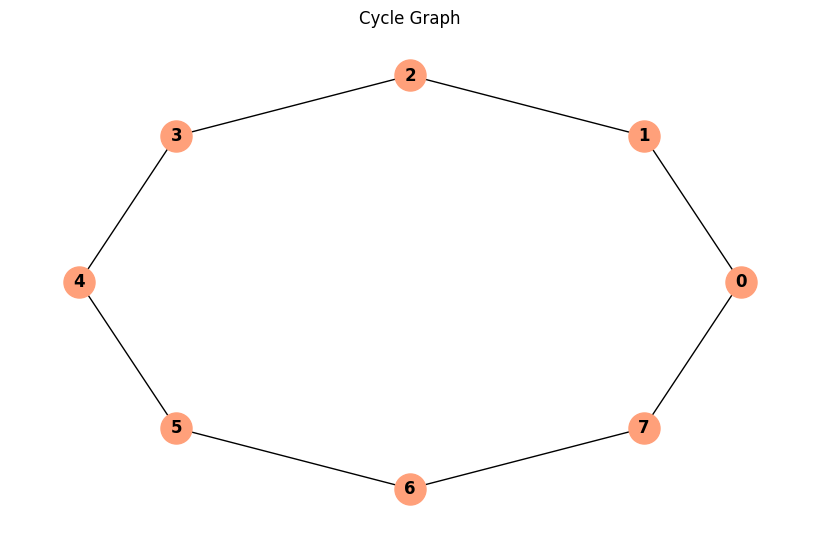

Did not converge after 15 iterations. Final change: 0.000004


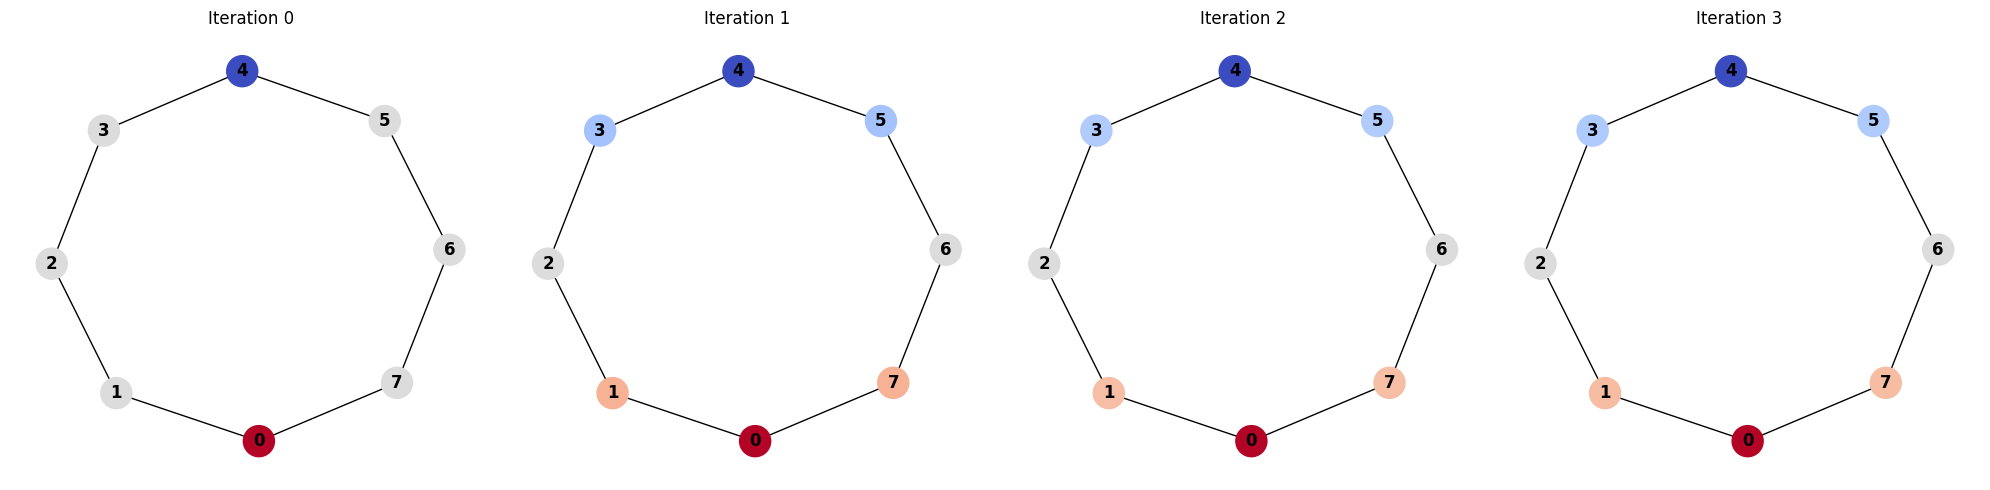

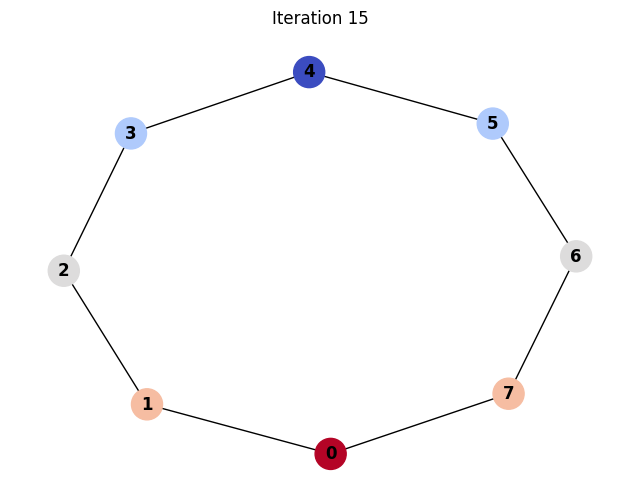

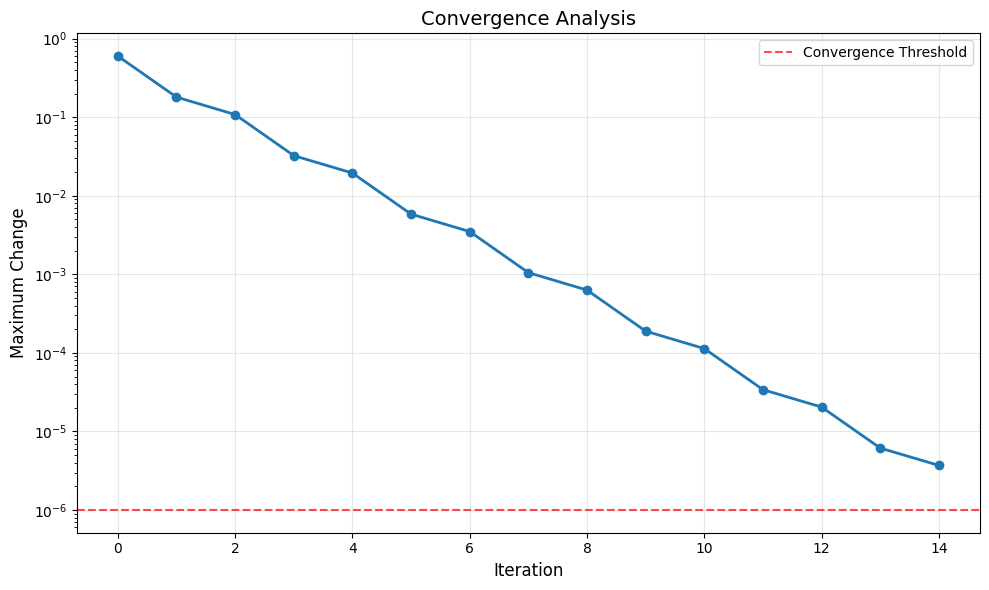

In [11]:
# Create a cycle graph
cycle_graph = nx.cycle_graph(8)
print(f"Cycle Graph with {len(cycle_graph.nodes())} nodes and {len(cycle_graph.edges())} edges")

# Visualize the graph
plt.figure(figsize=(8, 5))
pos = nx.circular_layout(cycle_graph)
nx.draw(cycle_graph, pos, with_labels=True, node_size=500, node_color='lightsalmon', font_weight='bold')
plt.title("Cycle Graph")
plt.show()

# Define node features - set two opposing nodes as information sources
node_features = {}
for node in cycle_graph.nodes():
    if node == 0:
        # First source with positive signal
        node_features[node] = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32)
    elif node == 4:
        # Second source with negative signal
        node_features[node] = torch.tensor([-1.0, 0.0, 0.0], dtype=torch.float32)
    else:
        # Other nodes have zero initial signal
        node_features[node] = torch.zeros(state_dim, dtype=torch.float32)

# Create a diffusion tracker
tracker = DiffusionTracker(cycle_graph, initial_states=node_features)

# Run the diffusion process
iterations = tracker.run_diffusion(
    transition_function=transition_fn,
    node_features=node_features,
    max_iterations=15,
    convergence_threshold=1e-6
)

# Visualize the diffusion process at key steps
visualize_diffusion_process(
    cycle_graph, 
    [tracker.get_state_at_iteration(i) for i in range(0, iterations+1, 3)],
    dim_idx=0,
    cmap='coolwarm'
)

# Create an animation of the complete diffusion process
anim = create_diffusion_animation(
    cycle_graph,
    [tracker.get_state_at_iteration(i) for i in range(iterations+1)],
    dim_idx=0
)

# Display the animation
HTML(anim.to_jshtml())

# Plot convergence metrics
plot_convergence_metrics(tracker.get_convergence_metrics())

In the cycle graph with opposing sources, we can observe how the two signals propagate and eventually reach a balanced equilibrium. This demonstrates how GNNs can handle complex patterns of information flow.

## 2. Exploring Different Transition Functions

Now, let's compare how different transition functions affect the diffusion process. We'll use the MLP-based transition function that we defined in Part 1.

Grid Graph with 9 nodes and 12 edges


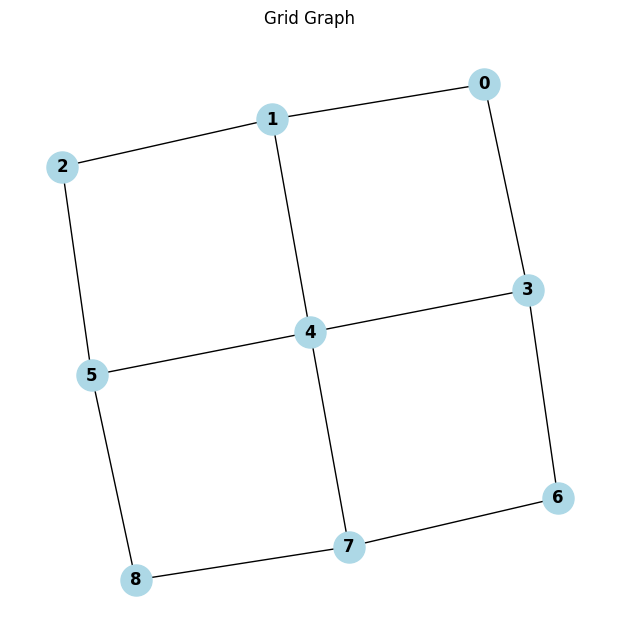

Did not converge after 20 iterations. Final change: 0.000014
Converged after 8 iterations


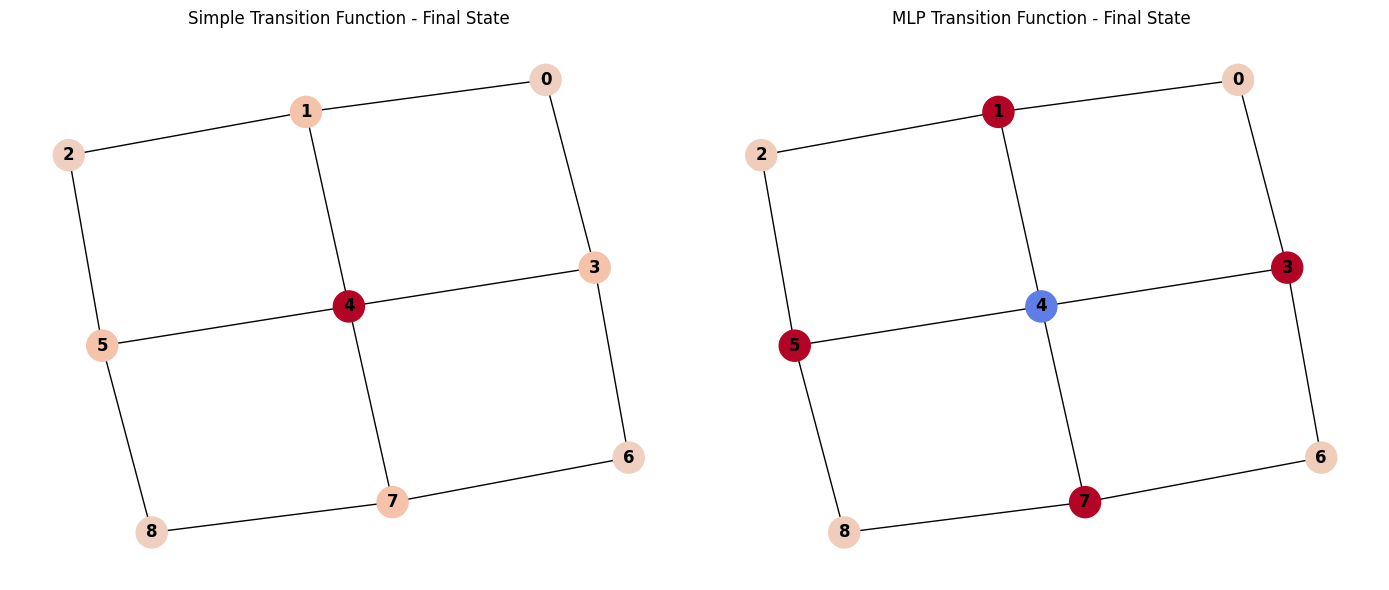

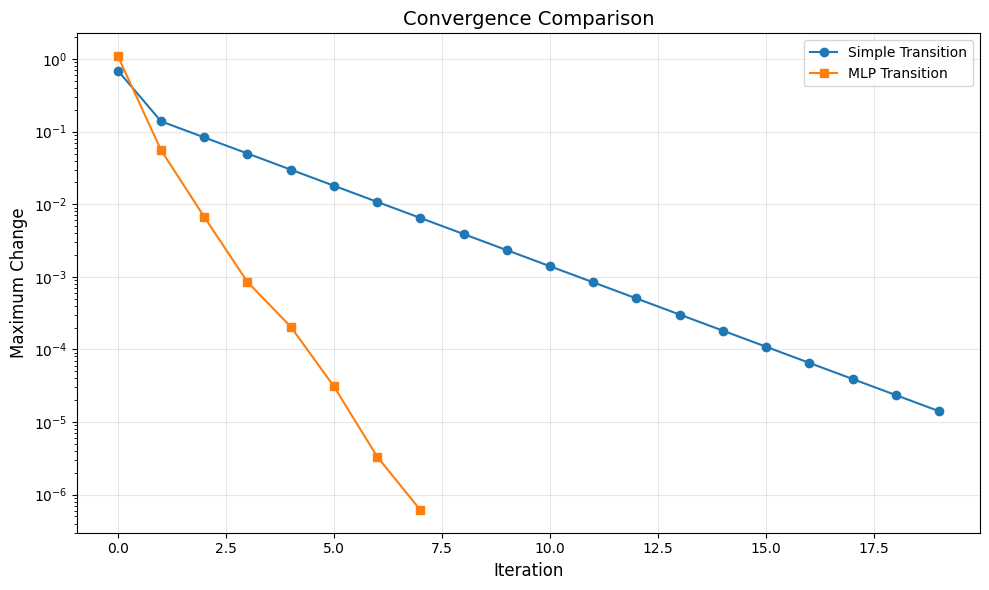

In [12]:
# Create a simple graph for the comparison
graph = nx.grid_2d_graph(3, 3)  # 3x3 grid
# Convert node labels to integers for simplicity
graph = nx.convert_node_labels_to_integers(graph)
print(f"Grid Graph with {len(graph.nodes())} nodes and {len(graph.edges())} edges")

# Visualize the graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(graph, seed=42)
nx.draw(graph, pos, with_labels=True, node_size=500, node_color='lightblue', font_weight='bold')
plt.title("Grid Graph")
plt.show()

# Define node features - central node as the source
state_dim = 3
feature_dim = 3
node_features = {}
for node in graph.nodes():
    if node == 4:  # Center node
        # Center node has a strong initial signal
        node_features[node] = torch.tensor([1.0, 0.5, -0.3], dtype=torch.float32)
    else:
        # Other nodes have zero initial signal
        node_features[node] = torch.zeros(state_dim, dtype=torch.float32)

# Define two different transition functions
simple_transition = SimpleTransitionFunction(state_dim=state_dim, diffusion_rate=0.6)
mlp_transition = MLPTransitionFunction(feature_dim=feature_dim, state_dim=state_dim, hidden_dim=8)

# Run diffusion with the simple transition function
simple_tracker = DiffusionTracker(graph, initial_states=node_features)
simple_iterations = simple_tracker.run_diffusion(
    transition_function=simple_transition,
    node_features=node_features,
    max_iterations=20,
    convergence_threshold=1e-6
)

# Run diffusion with the MLP transition function
mlp_tracker = DiffusionTracker(graph, initial_states=node_features)
mlp_iterations = mlp_tracker.run_diffusion(
    transition_function=mlp_transition,
    node_features=node_features,
    max_iterations=20,
    convergence_threshold=1e-6
)

# Visualize the final states for both methods
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Simple transition final state
visualize_diffusion_step(
    graph, 
    simple_tracker.get_state_at_iteration(simple_iterations),
    pos, dim_idx=0, cmap='coolwarm', ax=axes[0]
)
axes[0].set_title("Simple Transition Function - Final State")
axes[0].axis('off')

# MLP transition final state
visualize_diffusion_step(
    graph, 
    mlp_tracker.get_state_at_iteration(mlp_iterations),
    pos, dim_idx=0, cmap='coolwarm', ax=axes[1]
)
axes[1].set_title("MLP Transition Function - Final State")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Compare convergence behavior
plt.figure(figsize=(10, 6))
plt.plot(simple_tracker.get_convergence_metrics(), 'o-', label='Simple Transition')
plt.plot(mlp_tracker.get_convergence_metrics(), 's-', label='MLP Transition')
plt.yscale('log')
plt.title('Convergence Comparison', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Maximum Change', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

This comparison demonstrates how different transition functions can lead to different diffusion patterns and convergence behaviors.

## 3. The Impact of Initialization on Convergence

The initialization of node states plays a crucial role in the diffusion process. Let's explore different initialization strategies and analyze their impact on convergence.

Did not converge after 20 iterations. Final change: 0.000012
Did not converge after 20 iterations. Final change: 0.000003
Converged after 1 iterations
Converged after 14 iterations


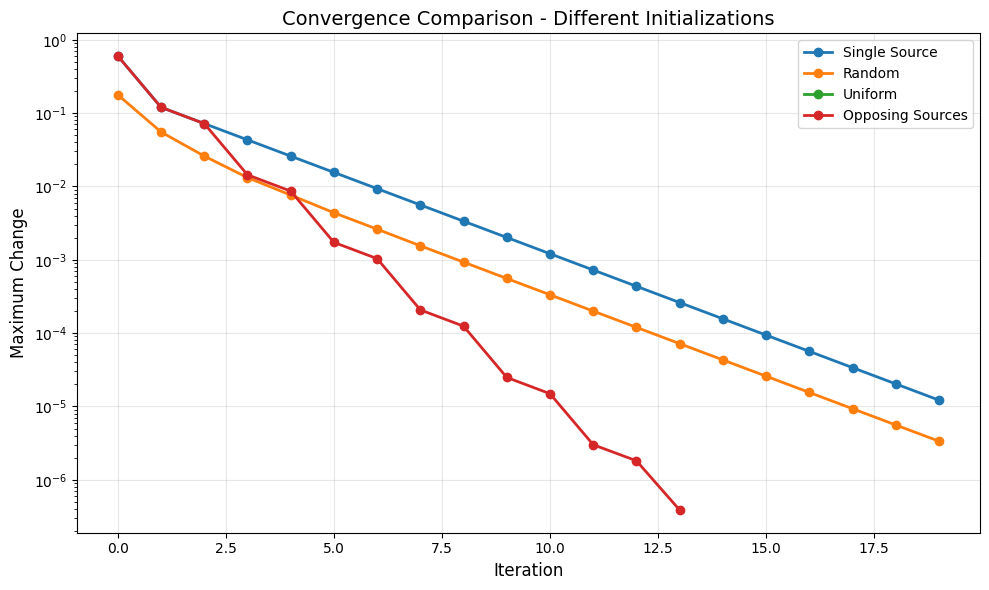

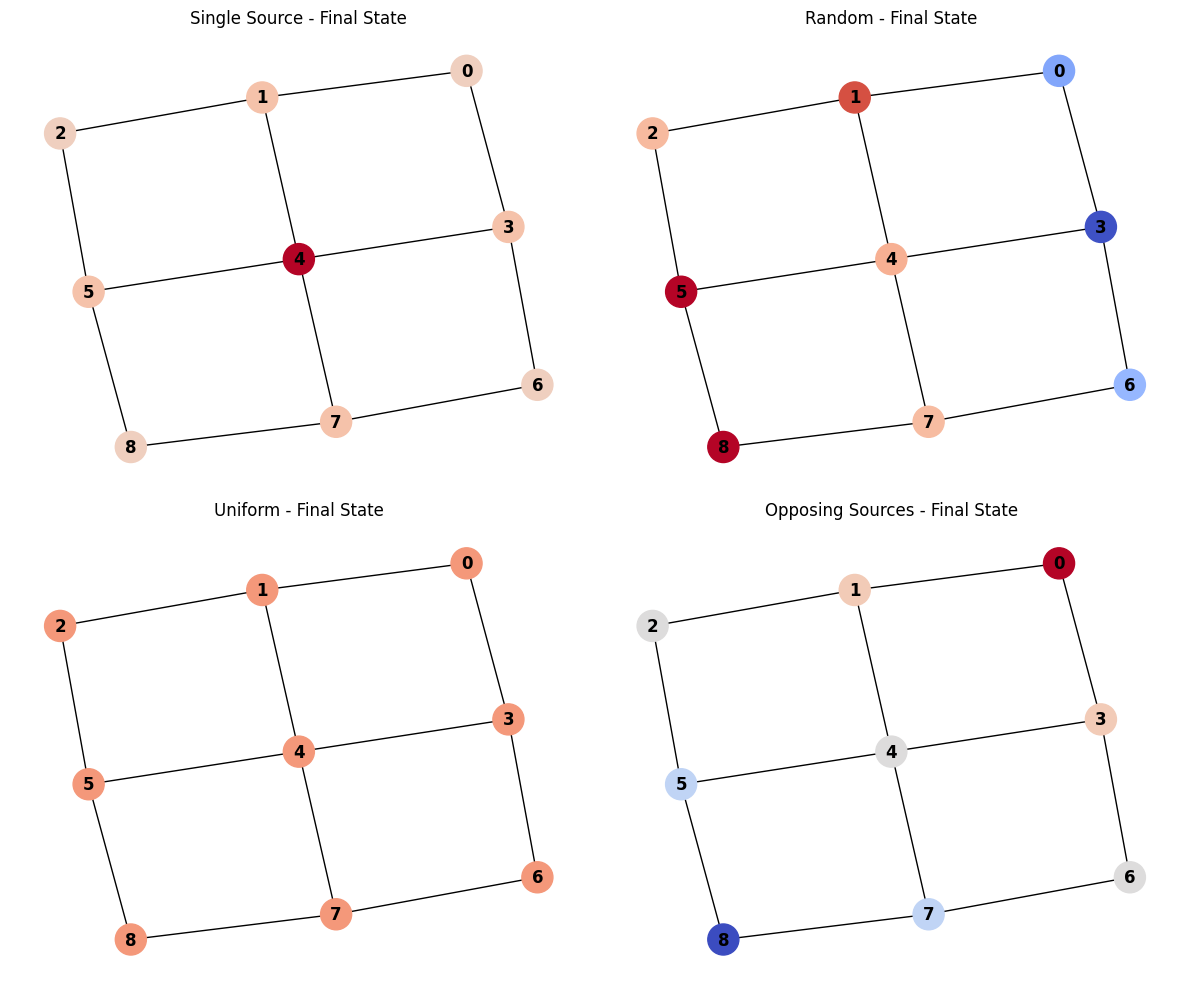

In [13]:
# Use the same grid graph as before
graph = nx.grid_2d_graph(3, 3)
graph = nx.convert_node_labels_to_integers(graph)

# Define a consistent transition function
transition_fn = SimpleTransitionFunction(state_dim=state_dim, diffusion_rate=0.6)

# Define different initialization strategies
initializations = {
    "Single Source": {node: torch.tensor([1.0, 0.0, 0.0]) if node == 4 else torch.zeros(3) for node in graph.nodes()},
    "Random": {node: torch.randn(3) * 0.1 for node in graph.nodes()},
    "Uniform": {node: torch.ones(3) * 0.5 for node in graph.nodes()},
    "Opposing Sources": {
        node: torch.tensor([1.0, 0.0, 0.0]) if node == 0 else 
             (torch.tensor([-1.0, 0.0, 0.0]) if node == 8 else torch.zeros(3)) 
        for node in graph.nodes()
    }
}

# Run diffusion for each initialization strategy
results = {}
for name, init_states in initializations.items():
    tracker = DiffusionTracker(graph, initial_states=init_states)
    iterations = tracker.run_diffusion(
        transition_function=transition_fn,
        node_features=init_states,
        max_iterations=20,
        convergence_threshold=1e-6
    )
    results[name] = {
        'tracker': tracker,
        'iterations': iterations
    }

# Compare convergence behavior
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['tracker'].get_convergence_metrics(), marker='o', linestyle='-', linewidth=2, label=name)

plt.yscale('log')
plt.title('Convergence Comparison - Different Initializations', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Maximum Change', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize the final states for different initializations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

pos = nx.spring_layout(graph, seed=42)  # Consistent layout

for i, (name, result) in enumerate(results.items()):
    visualize_diffusion_step(
        graph, 
        result['tracker'].get_state_at_iteration(result['iterations']),
        pos, dim_idx=0, cmap='coolwarm', ax=axes[i]
    )
    axes[i].set_title(f"{name} - Final State")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This analysis shows how different initialization strategies can lead to different diffusion dynamics and convergence patterns, even with the same underlying transition function.

## 4. Theoretical Analysis of Diffusion Properties

Let's delve deeper into the theoretical aspects of diffusion in GNNs, specifically focusing on the following key properties:

### 4.1 Contractive Property Analysis

The contraction property is crucial for ensuring convergence. Let's implement a function to verify this property for a given transition function:

Simple Transition Contraction Ratios: [0.47550609081495765, 0.491536299600971, 0.5843199420855668, 0.5590862774983105, 0.49569277379423, 0.6606804019521503, 0.5769700163768124, 0.5937145038138176, 0.7905791705570558, 0.5396235919345754]
Average Simple Ratio: 0.5767709068428448

MLP Transition Contraction Ratios: [0.15970309415459638, 0.19790708362732398, 0.15962743250611006, 0.16311318323421412, 0.22807373468149952, 0.19509061173894635, 0.16414282509619382, 0.2019479671801839, 0.18577819162418532, 0.24788931967527247]
Average MLP Ratio: 0.19032734435185258


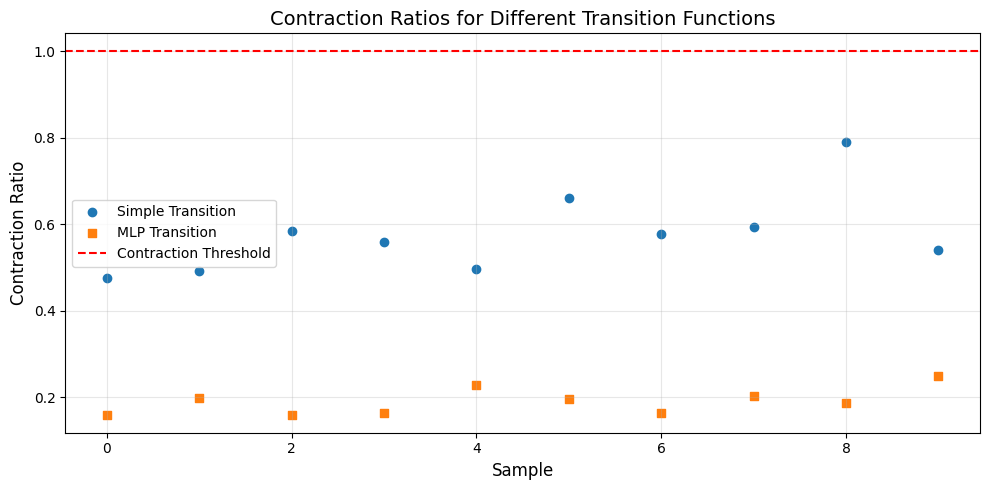

In [14]:
def verify_contraction_property(transition_function, graph, num_samples=10):
    """
    Verify the contraction property of a transition function on a graph.
    
    Args:
        transition_function: Function that computes new state from node features and neighbor states
        graph: NetworkX graph
        num_samples: Number of random state pairs to test
        
    Returns:
        List of contraction ratios (should all be less than 1)
    """
    state_dim = 3  # Assumes states are 3-dimensional
    contraction_ratios = []
    
    for _ in range(num_samples):
        # Generate two random state dictionaries
        states_x = {node: torch.randn(state_dim) for node in graph.nodes()}
        states_y = {node: torch.randn(state_dim) for node in graph.nodes()}
        
        # Compute the distance between initial states
        initial_distance = sum(
            torch.norm(states_x[node] - states_y[node]).item() 
            for node in graph.nodes()
        )
        
        # Apply the transition function to both states
        new_states_x = {}
        new_states_y = {}
        for node in graph.nodes():
            # Get neighbor states
            neighbors = list(graph.neighbors(node))
            x_neighbor_states = [states_x[neigh] for neigh in neighbors]
            y_neighbor_states = [states_y[neigh] for neigh in neighbors]
            
            # Update states using transition function
            new_states_x[node] = transition_function(states_x[node], x_neighbor_states, None)
            new_states_y[node] = transition_function(states_y[node], y_neighbor_states, None)
        
        # Compute the distance between updated states
        updated_distance = sum(
            torch.norm(new_states_x[node] - new_states_y[node]).item() 
            for node in graph.nodes()
        )
        
        # Compute contraction ratio
        if initial_distance > 0:
            ratio = updated_distance / initial_distance
            contraction_ratios.append(ratio)
    
    return contraction_ratios

# Test contraction property for our transition functions
simple_ratios = verify_contraction_property(simple_transition, graph)
mlp_ratios = verify_contraction_property(mlp_transition, graph)

print("Simple Transition Contraction Ratios:", simple_ratios)
print("Average Simple Ratio:", sum(simple_ratios) / len(simple_ratios))
print("\nMLP Transition Contraction Ratios:", mlp_ratios)
print("Average MLP Ratio:", sum(mlp_ratios) / len(mlp_ratios))

# Visualize contraction ratios
plt.figure(figsize=(10, 5))
plt.scatter(range(len(simple_ratios)), simple_ratios, label='Simple Transition', marker='o')
plt.scatter(range(len(mlp_ratios)), mlp_ratios, label='MLP Transition', marker='s')
plt.axhline(y=1.0, color='r', linestyle='--', label='Contraction Threshold')
plt.title('Contraction Ratios for Different Transition Functions', fontsize=14)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Contraction Ratio', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### 4.2 Information Propagation Distance Analysis

Let's analyze how many iterations it takes for information to propagate a certain distance in the graph:

Did not converge after 30 iterations. Final change: 0.000000
Converged after 11 iterations
    Node  Distance  Simple Transition  MLP Transition
0      0         4                inf             inf
1      1         3                inf             inf
2      2         2                inf             inf
3      3         3                inf             inf
4      4         4                inf             inf
5      5         3                inf             inf
6      6         2                inf             inf
7      7         1                1.0             inf
8      8         2                inf             inf
9      9         3                inf             inf
10    10         2                inf             inf
11    11         1                1.0             inf
12    12         0                0.0             0.0
13    13         1                1.0             inf
14    14         2                inf             inf
15    15         3                inf        

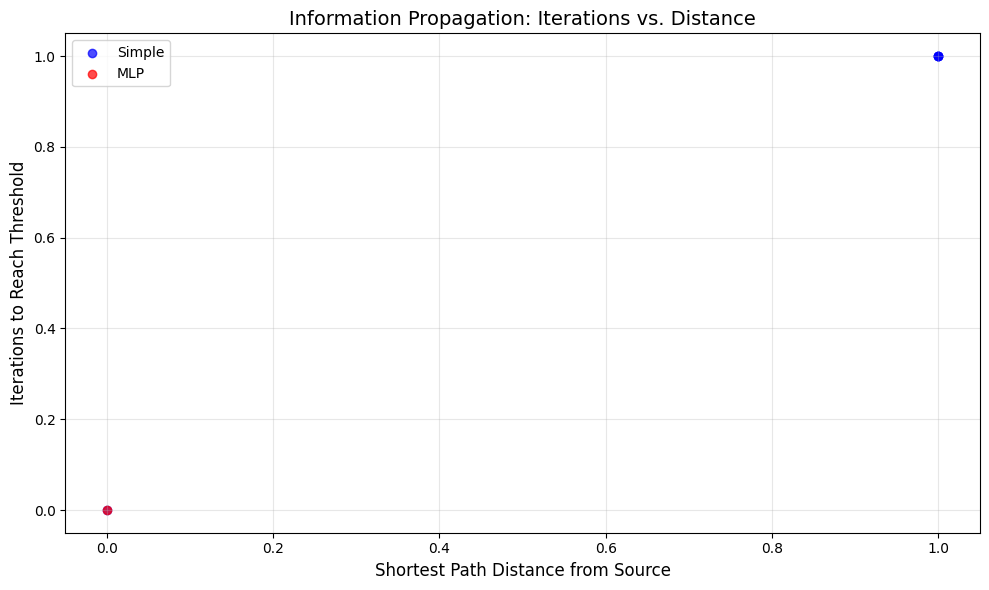

In [15]:
def analyze_information_propagation(graph, source_node, transition_function, threshold=0.1):
    """
    Analyze how long it takes for information to propagate from a source node to other nodes.
    
    Args:
        graph: NetworkX graph
        source_node: Source node of the information
        transition_function: Function that computes new state from node features and neighbor states
        threshold: Threshold to consider a node 'informed'
        
    Returns:
        Dictionary mapping node IDs to the number of iterations needed to reach the threshold
    """
    state_dim = 3
    
    # Initialize states - only source node has non-zero state
    node_features = {}
    for node in graph.nodes():
        if node == source_node:
            node_features[node] = torch.tensor([1.0, 0.0, 0.0])
        else:
            node_features[node] = torch.zeros(state_dim)
    
    # Create diffusion tracker
    tracker = DiffusionTracker(graph, initial_states=node_features)
    
    # Run diffusion for a fixed number of iterations
    iterations = tracker.run_diffusion(
        transition_function=transition_function,
        node_features=node_features,
        max_iterations=30,
        convergence_threshold=1e-9  # Very small threshold to ensure we run the full iterations
    )
    
    # For each node, determine first iteration where it exceeds the threshold
    first_informed = {}
    for node in graph.nodes():
        if node == source_node:
            first_informed[node] = 0  # Source is already informed
            continue
        
        for i in range(iterations + 1):
            state = tracker.get_state_at_iteration(i)[node]
            if torch.abs(state[0]).item() >= threshold:
                first_informed[node] = i
                break
        else:
            first_informed[node] = float('inf')  # Node never reached threshold
    
    return first_informed

# Use a larger graph for more meaningful analysis
larger_graph = nx.grid_2d_graph(5, 5)
larger_graph = nx.convert_node_labels_to_integers(larger_graph)

# Analyze information propagation
center_node = 12  # Center of the 5x5 grid
simple_propagation = analyze_information_propagation(larger_graph, center_node, simple_transition)
mlp_propagation = analyze_information_propagation(larger_graph, center_node, mlp_transition)

# Compute shortest path distances from source node
distances = {node: nx.shortest_path_length(larger_graph, source=center_node, target=node) 
             for node in larger_graph.nodes()}

# Create a DataFrame for analysis
import pandas as pd
propagation_df = pd.DataFrame({
    'Node': list(larger_graph.nodes()),
    'Distance': [distances[node] for node in larger_graph.nodes()],
    'Simple Transition': [simple_propagation[node] for node in larger_graph.nodes()],
    'MLP Transition': [mlp_propagation[node] for node in larger_graph.nodes()]
})

# Display results
print(propagation_df)

# Plot iterations vs. distance
plt.figure(figsize=(10, 6))
for dist in sorted(set(distances.values())):
    nodes = [node for node, d in distances.items() if d == dist]
    simple_iters = [simple_propagation[node] for node in nodes]
    mlp_iters = [mlp_propagation[node] for node in nodes]
    
    plt.scatter([dist] * len(nodes), simple_iters, color='blue', alpha=0.7, label='Simple' if dist == 1 else "")
    plt.scatter([dist] * len(nodes), mlp_iters, color='red', alpha=0.7, label='MLP' if dist == 1 else "")

plt.title('Information Propagation: Iterations vs. Distance', fontsize=14)
plt.xlabel('Shortest Path Distance from Source', fontsize=12)
plt.ylabel('Iterations to Reach Threshold', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Conclusion and Key Insights

In this notebook, we've explored the information diffusion mechanism in Graph Neural Networks, which is fundamental to their ability to capture graph-structured data. Let's summarize the key insights:

1. **Information Diffusion Process**: We've seen how information propagates through a graph structure step by step, with each node updating its state based on its neighborhood. This allows nodes to incorporate information from distant parts of the graph after multiple iterations.

2. **Banach Fixed Point Theorem**: The theory behind GNNs relies on the Banach fixed point theorem, which guarantees convergence if the transition function is a contraction mapping. We've analyzed this property for different transition functions.

3. **Diffusion Patterns**: Different graph structures lead to different diffusion patterns. In path graphs, information flows linearly; in trees, it branches out; and in cycles, it can flow in multiple directions and create interference patterns.

4. **Transition Functions**: The choice of transition function affects both the diffusion pattern and the convergence rate. More complex functions like MLPs can learn more sophisticated diffusion patterns.

5. **Initialization Strategies**: Different initial states can lead to different equilibrium states and convergence behaviors, even with the same transition function.

6. **Information Propagation Distance**: The number of iterations required for information to reach a node is roughly proportional to its shortest path distance from the source, though the exact relationship depends on the transition function.

These insights help us understand why GNNs are effective for graph-structured data and how they capture both local and global information through the diffusion process. 

In the next notebook, we'll explore how to optimize the parameters of a GNN through learning, using the information diffusion mechanism as a foundation.